Configuración


In [ ]:
import os
import sys


PROJECT_ROOT = os.path.abspath("../../..")
sys.path.append(PROJECT_ROOT)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from src.fer.models.vit.model import get_base_model, get_transforms


# --- CONFIGURACIÓN DEL ENTRENAMIENTO ---
BATCH_SIZE = 16
EPOCHS = 10          # Tiempo suficiente
LR = 1e-5            # Velocidad rápida

# Rutas de datos
DATA_ROOT = os.path.join(PROJECT_ROOT, "src\data")
MODEL_OUT = os.path.join(PROJECT_ROOT, "src", "fer", "train", "vit_emotions.pt")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

Dispositivo: cuda


Carga de datos


In [ ]:
# Obtener transformaciones para los datos
transform_train, transform_val = get_transforms()

train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "validation")


train_ds = ImageFolder(train_dir, transform=transform_train)
val_ds   = ImageFolder(val_dir, transform=transform_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f" Imágenes Train: {len(train_ds)}")
print(f" Imágenes Val:   {len(val_ds)}")
print(f" Clases: {train_ds.classes}")

 Imágenes Train: 56000
 Imágenes Val:   7000
 Clases: ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']


Función de la estructura por epoch

In [27]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    # Barra de carga
    loop = tqdm(loader, desc="Train", leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # ViT devuelve un objeto, extraemos .logits
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        # Clipping para estabilidad
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Métricas
        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        loop.set_postfix(loss=loss.item())
        
    return total_loss / len(loader), correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device, desc="Val"):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc=desc, leave=False):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        
        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    return total_loss / len(loader), correct / total

Para ir mejorando un modelo que ya tenemos primero ponemos el accuracy de este como record a batir.

In [ ]:
best_acc = 0.0

# (Consultar récord anterior) 
if os.path.exists(MODEL_OUT):
    try:
        # Cargar modelo temporalmente
        temp_model = get_base_model(device)
        temp_model.load_state_dict(torch.load(MODEL_OUT, map_location=device))
        
        # Evaluar
        criterion_temp = nn.CrossEntropyLoss()
        _, best_acc = evaluate(temp_model, val_loader, criterion_temp, device, desc="Checkeo Récord")
        
        print(f"Récord a batir: {best_acc:.4f}")
        
        # Borrar rastro
        del temp_model
        torch.cuda.empty_cache()
    except Exception as e:
        print(f" Error leyendo modelo viejo: {e}. Empezamos de 0.")
else:
    print("ℹ No hay historial. Récord inicial: 0.0")

# Aquí cargamos un modelo nuevo
model = get_base_model(device) 

# Actualizamos los pesos y el LearningRate
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


 Encontrado modelo previo en: c:\Users\joorg\Documents\ReconocimientoFacialEmociones\src\fer\train\vit_emotions.pt
 Comprobando su nota actual...
🏗️ Construyendo arquitectura ViT desde: mo-thecreator/vit-Facial-Expression-Recognition


C:\Users\joorg\AppData\Local\Temp\ipykernel_18408\3717336154.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  temp_model.load_state_dict(torch.load(MODEL_OUT, map_locati

Checkeo Récord:   0%|          | 0/438 [00:07<?, ?it/s]

🏆 Récord a batir: 0.8637

 INICIANDO ENTRENAMIENTO LIMPIO (Fresh Start)...
🏗️ Construyendo arquitectura ViT desde: mo-thecreator/vit-Facial-Expression-Recognition
 Todo listo para entrenar.


Bucle de entrenamiento

In [ ]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

print(f" Arrancando {EPOCHS} épocas. Objetivo: > {best_acc:.4f}")

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    
    # Entrenar
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    
    # Validar
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, desc="Validando")
    
    # Actualizar  learning rate y el scheduler
    scheduler.step()
    curr_lr = optimizer.param_groups[0]['lr']
    
    # Guardar métricas
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    
    print(f"LR: {curr_lr:.2e}")
    print(f"Train - Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
    
    # Comparamos con el recor establecido
    if val_acc > best_acc:
        print(f"¡NUEVO RÉCORD! ({val_acc:.4f} > {best_acc:.4f}) -> Guardando en disco...")
        best_acc = val_acc
        torch.save(model.state_dict(), MODEL_OUT)
    else:
        print(f"No mejora ({val_acc:.4f})")

 Arrancando 10 épocas. Objetivo: > 0.8637

Epoch 1/10


Train:   0%|          | 0/3500 [00:06<?, ?it/s]

Validando:   0%|          | 0/438 [00:06<?, ?it/s]

LR: 9.76e-06
Train - Loss: 0.7612 | Acc: 0.8661
Val   - Loss: 0.7685 | Acc: 0.8559
No mejora (0.8559)

Epoch 2/10


Train:   0%|          | 0/3500 [00:06<?, ?it/s]

Validando:   0%|          | 0/438 [00:06<?, ?it/s]

LR: 9.05e-06
Train - Loss: 0.6290 | Acc: 0.9234
Val   - Loss: 0.7733 | Acc: 0.8496
No mejora (0.8496)

Epoch 3/10


Train:   0%|          | 0/3500 [00:06<?, ?it/s]

Validando:   0%|          | 0/438 [00:06<?, ?it/s]

LR: 7.94e-06
Train - Loss: 0.5680 | Acc: 0.9473
Val   - Loss: 0.7932 | Acc: 0.8550
No mejora (0.8550)

Epoch 4/10


Train:   0%|          | 0/3500 [00:06<?, ?it/s]

Validando:   0%|          | 0/438 [00:06<?, ?it/s]

LR: 6.55e-06
Train - Loss: 0.5342 | Acc: 0.9629
Val   - Loss: 0.8135 | Acc: 0.8459
No mejora (0.8459)

Epoch 5/10


Train:   0%|          | 0/3500 [00:06<?, ?it/s]

Validando:   0%|          | 0/438 [00:06<?, ?it/s]

LR: 5.00e-06
Train - Loss: 0.5117 | Acc: 0.9722
Val   - Loss: 0.8187 | Acc: 0.8547
No mejora (0.8547)

Epoch 6/10


Train:   0%|          | 0/3500 [00:06<?, ?it/s]

Validando:   0%|          | 0/438 [00:07<?, ?it/s]

LR: 3.45e-06
Train - Loss: 0.4935 | Acc: 0.9804
Val   - Loss: 0.8272 | Acc: 0.8504
No mejora (0.8504)

Epoch 7/10


Train:   0%|          | 0/3500 [00:07<?, ?it/s]

Validando:   0%|          | 0/438 [00:07<?, ?it/s]

LR: 2.06e-06
Train - Loss: 0.4830 | Acc: 0.9848
Val   - Loss: 0.8152 | Acc: 0.8577
No mejora (0.8577)

Epoch 8/10


Train:   0%|          | 0/3500 [00:07<?, ?it/s]

Validando:   0%|          | 0/438 [00:06<?, ?it/s]

LR: 9.55e-07
Train - Loss: 0.4732 | Acc: 0.9886
Val   - Loss: 0.8358 | Acc: 0.8533
No mejora (0.8533)

Epoch 9/10


Train:   0%|          | 0/3500 [00:07<?, ?it/s]

Validando:   0%|          | 0/438 [00:07<?, ?it/s]

LR: 2.45e-07
Train - Loss: 0.4671 | Acc: 0.9912
Val   - Loss: 0.8254 | Acc: 0.8554
No mejora (0.8554)

Epoch 10/10


Train:   0%|          | 0/3500 [00:07<?, ?it/s]

Validando:   0%|          | 0/438 [00:07<?, ?it/s]

LR: 0.00e+00
Train - Loss: 0.4639 | Acc: 0.9927
Val   - Loss: 0.8255 | Acc: 0.8564
No mejora (0.8564)


Evaluación final con el dataset de test y métricas.

 EVALUACIÓN FINAL DEL MEJOR MODELO
 Mejor modelo cargado.
Usando split: TEST


C:\Users\joorg\AppData\Local\Temp\ipykernel_18408\3622655974.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_OUT, map_location=dev

Testing TEST:   0%|          | 0/438 [00:06<?, ?it/s]


              precision    recall  f1-score   support

       Anger       0.87      0.78      0.83      1000
     Disgust       0.95      0.92      0.93      1000
        Fear       0.79      0.78      0.79      1000
   Happiness       0.93      0.96      0.95      1000
     Neutral       0.79      0.92      0.85      1000
     Sadness       0.81      0.80      0.80      1000
    Surprise       0.93      0.93      0.93      1000

    accuracy                           0.87      7000
   macro avg       0.87      0.87      0.87      7000
weighted avg       0.87      0.87      0.87      7000



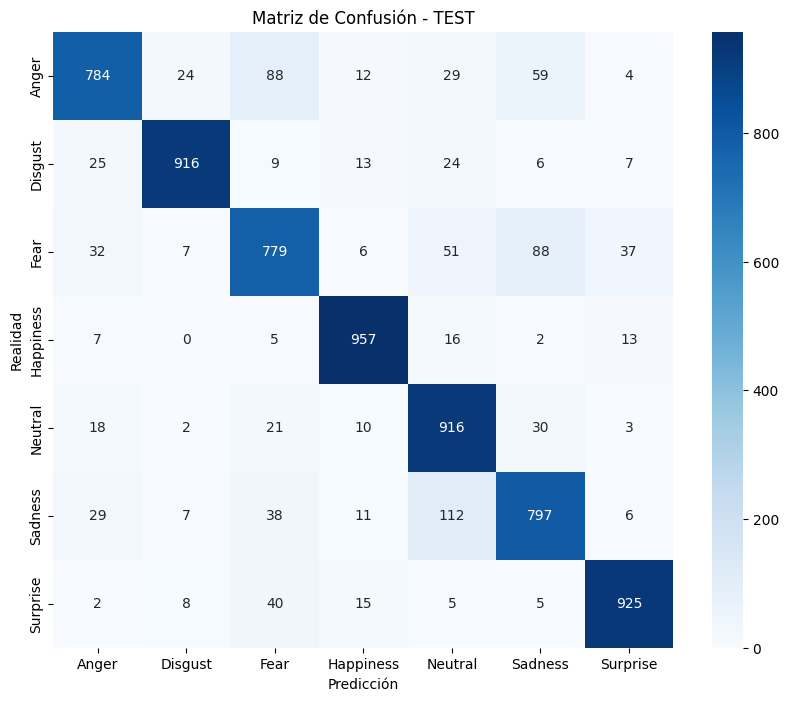

In [ ]:


if os.path.exists(MODEL_OUT):
    model.load_state_dict(torch.load(MODEL_OUT, map_location=device))

model.eval()

test_dir = os.path.join(DATA_ROOT, "test")
#Si no la encuentra que use la de validation
target_dir = test_dir if os.path.exists(test_dir) else val_dir
name_split = "TEST" if os.path.exists(test_dir) else "VALIDATION (Fallback)"


# Loader específico para test
test_ds = ImageFolder(target_dir, transform=transform_val)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Predecir
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc=f"Testing {name_split}"):
        images = images.to(device)
        outputs = model(images).logits
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#  Resultados Visuales
print("\n" + classification_report(all_labels, all_preds, target_names=test_ds.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.title(f'Matriz de Confusión - {name_split}')
plt.show()